# Light curves with Dataset

## Introduction

This tutorial presents a new light curve estimator that works with dataset objects, in particular MapDataset objects. Here we explain how to compute a light curve from 3D data cubes with Gammapy.

This new estimator will replace the existing one in future gammapy releases. 

We will use the four Crab nebula observations from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/) and compute per-observation fluxes. The Crab nebula is not known to be variable at TeV energies, so we expect constant brightness within statistical and systematic errors.

The main classes we will use are:

* [gammapy.time.LightCurve](https://docs.gammapy.org/dev/api/gammapy.time.LightCurve.html)
* [gammapy.time.LightCurveEstimatorNew](https://docs.gammapy.org/dev/api/gammapy.time.LightCurveEstimatorNew.html)

## Setup

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.data import ObservationFilter, DataStore
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyPointSource
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.cube import PSFKernel, MapMaker, MapDataset
from gammapy.maps import WcsGeom, MapAxis
from gammapy.irf import make_mean_psf, make_mean_edisp
from gammapy.time import LightCurveEstimator3D

## Select the data

We look for relevant observations in the datastore.

In [3]:
data_store = DataStore.from_file(
    "$GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
crab_obs = data_store.get_observations(obs_ids)

## Define time intervals
We create a list of time intervals. Here we use one time bin per observation.

In [4]:
time_intervals = [(obs.tstart, obs.tstop) for obs in crab_obs]

## Define the analysis geometry

Here we define the geometry used in the analysis. We use the same WCS map structure but we use two different binnings for reco and true energy axes. This allows for a broader coverage of the response.

In [5]:
# Target definition
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")

# Define geoms
emin, emax = [0.7, 10] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 10, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.04,
    width=(2, 2),
    coordsys="CEL",
    proj="CAR",
    axes=[energy_axis],
)

etrue_axis = MapAxis.from_bounds(
    0.1, 20, 20, unit="TeV", name="energy", interp="log"
)

geom_true = WcsGeom.create(
    skydir=target_position,
    binsz=0.04,
    width=(2, 2),
    coordsys="CEL",
    proj="CAR",
    axes=[etrue_axis],
)

## Define the 3D model 

The light curve is based on a 3D fit of a map dataset in time bins. We therefore need to define the source model to be applied. Here a point source with power law spectrum. We freeze its parameters assuming they were previously extracted

In [6]:
# Define the source model - Use a pointsource + integrated power law model to directly get flux

spatial_model = SkyPointSource(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLaw(
    index=2.6,
    amplitude=2.0e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name=""
)
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True

## Data reduction: making the MapDatasets

The following function is in charge of the MapDataset production. It will later be fully covered in the data reduction chain 

In [7]:
# psf_kernel and MapMaker for each segment
def make_mapdataset(
    observations, target_pos, geom, geom_true, offset_max=2 * u.deg
):
    maker = MapMaker(geom, offset_max, geom_true=geom_true)
    maps = maker.run(observations)
    table_psf = make_mean_psf(observations, target_position)

    # PSF kernel used for the model convolution
    psf_kernel = PSFKernel.from_table_psf(
        table_psf, geom_true, max_radius="0.3 deg"
    )
    edisp = make_mean_edisp(
        observations,
        target_position,
        e_true=geom_true.axes[0].edges,
        e_reco=geom.axes[0].edges,
    )
    background_model = BackgroundModel(maps["background"])
    background_model.parameters["norm"].frozen = False
    background_model.parameters["tilt"].frozen = True

    dataset = MapDataset(
        counts=maps["counts"],
        exposure=maps["exposure"],
        background_model=background_model,
        psf=psf_kernel,
        edisp=edisp,
    )
    return dataset

Now we perform the actual data reduction in time bins

In [8]:
%%time

datasets = []

for time_interval in time_intervals:
    # get filtered observation lists in time interval
    obs = crab_obs.select_time(time_interval)
    # Proceed with further analysis only if there are observations 
    # in the selected time window
    if len(obs) == 0:
        log.warning("No observations found in time interval:" 
                    "{t_min} - {t_max}".format(t_min=time_interval[0],
                                               t_max=time_interval[1]) 
                   )
        continue
    dataset = make_mapdataset(obs, target_position, geom, geom_true)
    dataset.counts.meta["t_start"] = time_interval[0]
    dataset.counts.meta["t_stop"] = time_interval[1]
    datasets.append(dataset)

CPU times: user 3.5 s, sys: 146 ms, total: 3.65 s
Wall time: 3.69 s


Once we have created the datasets we assign them the model to be fitted. 

In [9]:
for dataset in datasets:
    # Copy the source model
    model = sky_model.copy()
    model.name = "crab"
    dataset.model = model

## Light Estimator creation

We can now create the light curve estimator by passing it the list of datasets. 
We can optionally ask for parameters reoptimization during fit, e.g. to fit background normalization in each time bin.

In [10]:
lc_maker = LightCurveEstimator3D(datasets, source="crab", reoptimize=False)

We now run the estimator once we pass it the energy interval on which to compute the integral flux of the source.

In [11]:
%%time
lc = lc_maker.run(eref=1 * u.TeV, emin=1.0 * u.TeV, emax=10.0 * u.TeV)

CPU times: user 10.6 s, sys: 259 ms, total: 10.9 s
Wall time: 11.6 s


The LightCurve object contains a table which we can explore.

In [12]:
lc.table["time_min", "time_max", "flux", "flux_err"]

time_min,time_max,flux,flux_err
,,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64
53343.92234009259,53343.94186555556,2.7339067197215866e-11,2.100460186805052e-12
53343.95421509259,53343.97369425926,2.4575209334948127e-11,2.027293009588302e-12
53345.96198129629,53345.98149518518,3.147648428762074e-11,2.783720854376958e-12
53347.913196574074,53347.93271046296,2.8951354849167565e-11,2.626377535137574e-12


We finally plot the light curve

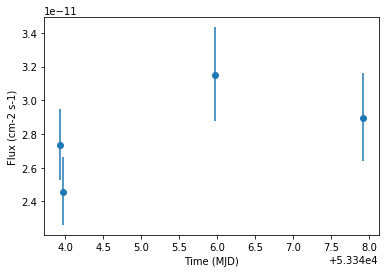

In [13]:
lc.plot(marker="o")